<a href="https://colab.research.google.com/github/carl-allen/carl-allen.github.io/blob/master/representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST with SciKit-Learn and skorch

This notebooks shows how to define and train a simple Neural-Network with PyTorch and use it via skorch with SciKit-Learn.

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

If you are running in colab, you should install the dependencies and download the dataset by running the following cell:

In [ ]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Loading Data
Using SciKit-Learns ```fetch_openml``` to load MNIST data.

In [ ]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
mnist.data.shape

(70000, 784)

## Preprocessing Data

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.<br />
The above ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively.

In [ ]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

To avoid big weights that deal with the pixel values from between [0, 255], we scale `X` down. A commonly used range is [0, 1].

In [ ]:
X /= 255.0

In [ ]:
X.min(), X.max()

(0.0, 1.0)

Note: data is not normalized.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [ ]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

### Print a selection of training images and their labels

In [ ]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

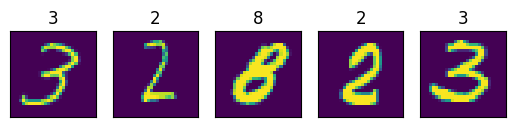

In [ ]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch
Simple, fully connected neural network with one hidden layer. Input layer has 784 dimensions (28x28), hidden layer has 98 (= 784 / 8) and output layer 10 neurons, representing digits 0 - 9.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
mnist_dim = X.shape[1]
hidden_dim1 = int(mnist_dim/8)
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

In [ ]:
mnist_dim, hidden_dim1, hidden_dim, output_dim

(784, 98, 98, 10)

A Neural network in PyTorch's framework.

In [ ]:
''' define MLP '''

class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            # hidden_dim1=hidden_dim1,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        # self.hidden1 = nn.Linear(input_dim, hidden_dim1)
        # self.hidden = nn.Linear(hidden_dim1, hidden_dim)
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def rep(self, X, **kwargs):
        # X = self.hidden1(X)
        # X = F.relu(X)
        X = self.hidden(X)
        X = F.relu(X)
        return X

    def forward(self, X, **kwargs):
        X = self.rep(X)
        X = self.dropout(X)
        X = self.output(X)
        return F.softmax(X, dim=-1)

    def W(self):
        return list(self.output.parameters())


skorch allows to use PyTorch's networks in the SciKit-Learn setting:

In [ ]:
''' define CNN '''

class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        # self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc15 = nn.Linear(100, 100)
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def rep(self, x):
        x = self.conv1(x)
        x = torch.relu(F.max_pool2d(x, 2))
        x = self.conv2(x)
        # x = torch.relu(F.max_pool2d(x, 2))
        # x = self.conv3(x)
        x = self.conv2_drop(x)
        x = torch.relu(F.max_pool2d(x, 2))

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.fc1_drop(x)
        x = torch.relu(x)
        x = self.fc15(x)
        return x

    def forward(self, x):
        x = self.rep(x)
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

    def W(self):
        return list(self.fc2.parameters())



In [ ]:
''' define Resnet18 '''

# import torchvision.models as models
from typing import Any, Callable, List, Optional, Type, Union
from torch import Tensor
# from ..utils import _log_api_usage_once

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        # _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    # def _forward_impl(self, x: Tensor) -> Tensor:
    #     # See note [TorchScript super()]
    #     x = self.conv1(x)
    #     x = self.bn1(x)
    #     x = self.relu(x)
    #     x = self.maxpool(x)

    #     x = self.layer1(x)
    #     x = self.layer2(x)
    #     x = self.layer3(x)
    #     x = self.layer4(x)

    #     x = self.avgpool(x)
    #     x = torch.flatten(x, 1)
    #     x = self.fc(x)

    #     return x

    def rep_s(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def rep(self, x: Tensor) -> Tensor:
        x = self.avgpool(self.rep_s(x))
        x = torch.flatten(x, 1)
        return x

    def logit(self, x: Tensor) -> Tensor:
        return self.fc(self.rep(x))

    def forward(self, X, **kwargs):
        return F.softmax(self.logit(X), dim=-1)

    def W(self):
        return list(self.fc.parameters())


def get_resnet18():
    resnet = ResNet(BasicBlock, [2, 2, 2, 2])
    resnet.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    return resnet

In [ ]:
''' define all networks '''

from skorch import NeuralNetClassifier

models = {'mlp':    {'net': ClassifierModule, 'lr': 0.01},
          'cnn':    {'net': Cnn,              'lr': 0.002},
          'resnet': {'net': get_resnet18(),   'lr': 0.01}}

def get_net(model_type, max_epochs=20, cb=None):
    net = NeuralNetClassifier(
        models[model_type]['net'],
        max_epochs=max_epochs,
        lr=models[model_type]['lr'],
        optimizer=torch.optim.Adam,
        device=device,
        # criterion=torch.nn.CrossEntropyLoss,
        callbacks=cb,
    )
    return net

In [ ]:
def data_reshape(model_type, X_train, X_test):
    X_shape = (-1,28*28) if model_type in ['mlp'] else (-1,1,28,28)
    X_train, X_test = [np.reshape(x, X_shape) for x in [X_train, X_test]]
    return X_train, X_test


Training mlp
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5178       0.9325        0.2218  1.0450
      2        0.3633       0.9423        0.1968  1.1982
      3        0.3264       0.9464        0.1825  1.3652
      4        0.3115       0.9519        0.1678  1.0957
Callback after epoch 5 (1)
      5        0.2933       0.9517        0.1620  1.0611
      6        0.2995       0.9519        0.1743  1.0774
      7        0.2790       0.9511        0.1722  1.0498
      8        0.2732       0.9559        0.1601  1.0369
      9        0.2639       0.9561        0.1629  1.0473
Callback after epoch 10 (2)
     10        0.2671       0.9570        0.1554  1.0500
     11        0.2618       0.9545        0.1682  1.1272
     12        0.2581       0.9583        0.1527  1.3506
     13        0.2500       0.9590        0.1554  1.6218
     14        0.2492       0.9564        0.1655  1.2499
Callback after epoch

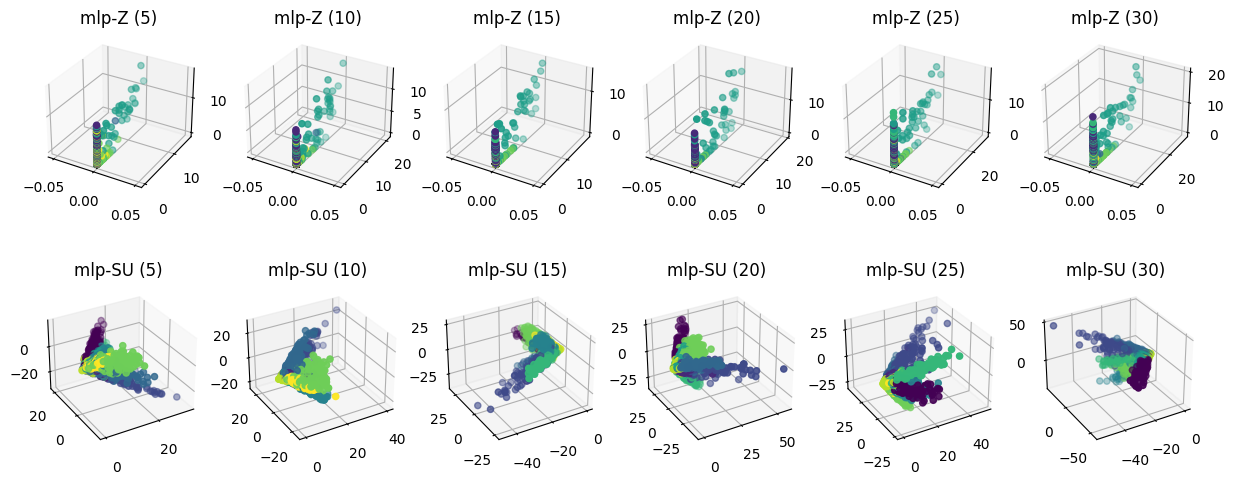

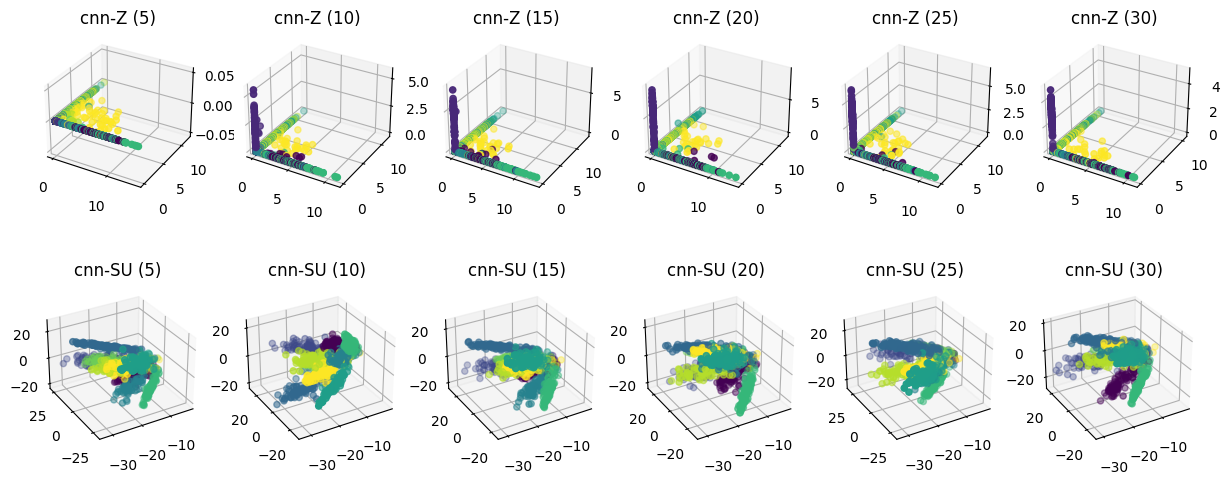

In [ ]:
# RERUNNING ABOVE, WITHOUT ADDITIONAL (1.5) LAYER I'D ADDED
from skorch.callbacks import Callback

max_epochs = 30
run_epochs = 5
num_runs = max_epochs // run_epochs
nets_test = {}

def calc_Z(model, batch):
    Z = model.rep(torch.tensor(X_test).to(device)).to('cpu').detach().numpy()
    U, S, Vh = np.linalg.svd(Z, full_matrices=False)
    return (Z, U, S)

class GraphStuff(Callback):
    def __init__(self, run_epochs, num_runs):
        self.num_runs   = num_runs
        self.run_epochs = run_epochs

    def initialize(self):
        self.fig = plt.figure(figsize=(self.num_runs*2.5,6))

    # This runs after every epoch
    def on_epoch_end(self, net, dataset_train, dataset_valid, n=1000):
        epoch = len(net.history)
        if (epoch % self.run_epochs) == 0:
            i = epoch // self.run_epochs
            print('Callback after epoch %d (%d)' % (epoch, i))
            Z, U, S = calc_Z(net.module_, dataset_valid)

            ax = self.fig.add_subplot(2, num_runs, i, projection='3d', title='%s-Z (%d)' % (model_type, epoch))
            ax.scatter(*(Z)[:n,:3].T, c=y_test[:n])
            ax = self.fig.add_subplot(2, num_runs, i+num_runs, projection='3d', title='%s-SU (%d)' % (model_type, epoch))
            ax.scatter(*(U*S)[:n,:3].T, c=y_test[:n])
            ax.view_init(elev=30, azim=-120)

cb = [GraphStuff(run_epochs, num_runs)]

for model_type in ['mlp', 'cnn']:
    print('Training %s' % model_type)

    X_train, X_test = data_reshape(model_type, X_train, X_test)
    torch.manual_seed(0)
    net = get_net(model_type, max_epochs=max_epochs, cb=cb)
    net.fit(X_train, y_train);
    nets_test[model_type] = net



Training mlp
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5178       0.9325        0.2218  1.1474
      2        0.3633       0.9423        0.1968  1.4085
      3        0.3264       0.9464        0.1825  1.0579
      4        0.3115       0.9519        0.1678  1.0528
Callback after epoch 5 (1)
      5        0.2933       0.9517        0.1620  1.0424
      6        0.2995       0.9519        0.1743  1.0666
      7        0.2790       0.9511        0.1722  1.0515
      8        0.2732       0.9559        0.1601  1.0769
      9        0.2639       0.9561        0.1629  1.0510
Callback after epoch 10 (2)
     10        0.2671       0.9570        0.1554  1.0291
     11        0.2618       0.9545        0.1682  1.1336
     12        0.2581       0.9583        0.1527  1.4355
     13        0.2500       0.9590        0.1554  1.1299
     14        0.2492       0.9564        0.1655  1.0495
Callback after epoch

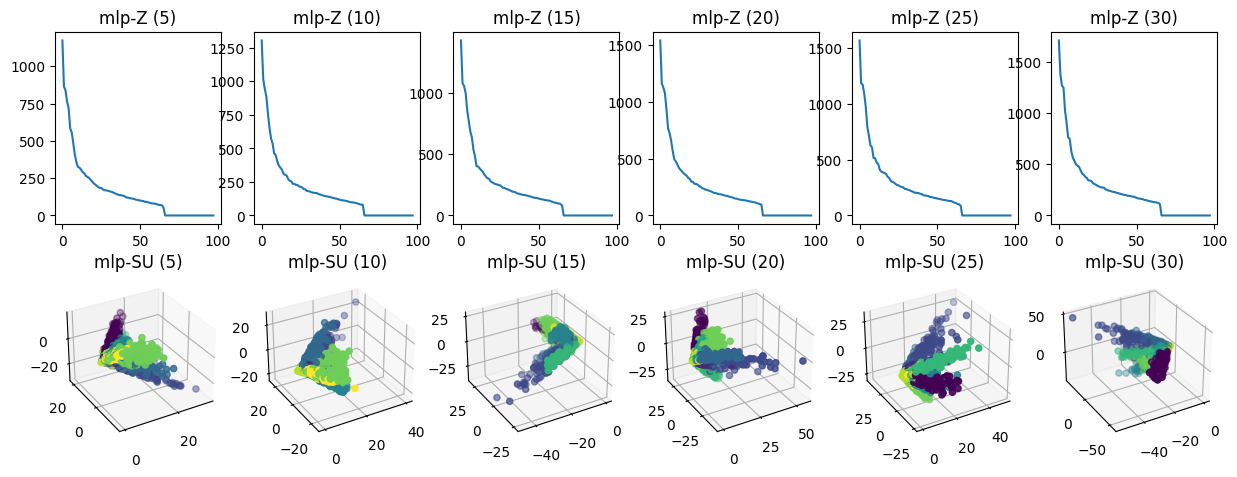

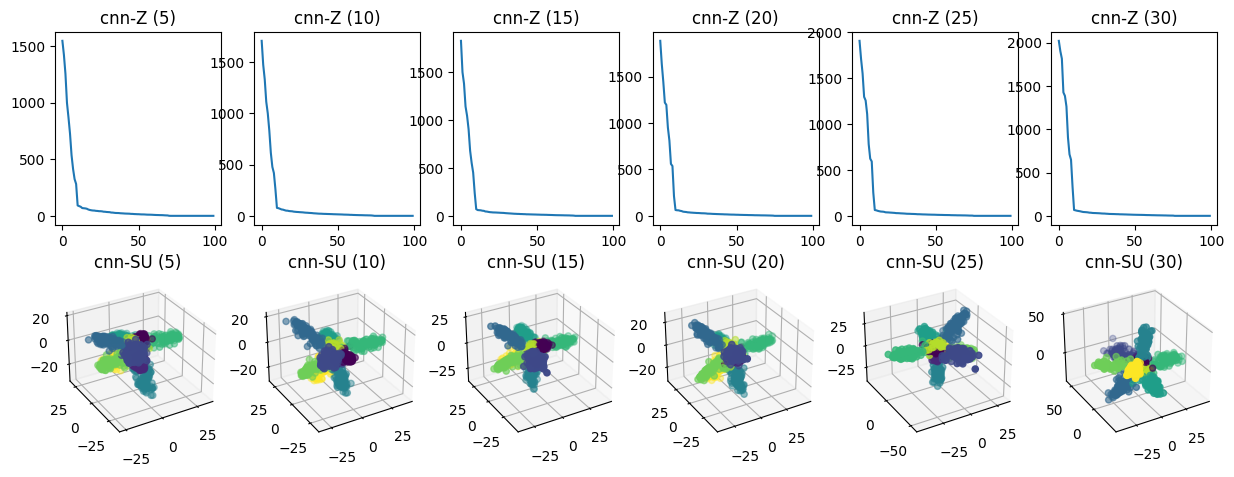

In [ ]:
# RERUNNING ABOVE, WITHOUT ADDITIONAL (1.5) LAYER I'D ADDED
from skorch.callbacks import Callback

max_epochs = 30
run_epochs = 5
num_runs = max_epochs // run_epochs
nets = {}

def calc_Z(model, batch):
    Z = model.rep(torch.tensor(X_test).to(device)).to('cpu').detach().numpy()
    U, S, Vh = np.linalg.svd(Z, full_matrices=False)
    return (Z, U, S)

class GraphStuff(Callback):
    def __init__(self, run_epochs, num_runs):
        self.num_runs   = num_runs
        self.run_epochs = run_epochs

    def initialize(self):
        self.fig = plt.figure(figsize=(self.num_runs*2.5,5.5))

    # This runs after every epoch
    def on_epoch_end(self, net, dataset_train, dataset_valid, n=1000):
        epoch = len(net.history)
        if (epoch % self.run_epochs) == 0:
            i = epoch // self.run_epochs
            print('Callback after epoch %d (%d)' % (epoch, i))
            Z, U, S = calc_Z(net.module_, dataset_valid)

            # ax = self.fig.add_subplot(2, num_runs, i, projection='3d', title='%s-Z (%d)' % (model_type, epoch))
            # ax.scatter(*(Z)[:n,:3].T, c=y_test[:n])
            ax = self.fig.add_subplot(2, num_runs, i, title='%s-Z (%d)' % (model_type, epoch))
            ax.plot(S, label=model_type)
            ax = self.fig.add_subplot(2, num_runs, i+num_runs, projection='3d', title='%s-SU (%d)' % (model_type, epoch))
            ax.scatter(*(U*S)[:n,:3].T, c=y_test[:n])
            ax.view_init(elev=30, azim=-120)

cb = [GraphStuff(run_epochs, num_runs)]

for model_type in ['mlp', 'cnn']:
    print('Training %s' % model_type)

    X_train, X_test = data_reshape(model_type, X_train, X_test)
    torch.manual_seed(0)
    net = get_net(model_type, max_epochs=max_epochs, cb=cb)
    net.fit(X_train, y_train);
    nets[model_type] = net

# nets = {}

# for model_type in ['mlp', 'cnn']:
#     print('Training %s' % model_type)

#     X_train, X_test = data_reshape(model_type, X_train, X_test)

#     torch.manual_seed(0)
#     net = get_net(model_type)
#     net.fit(X_train, y_train)
#     nets[model_type] = net;

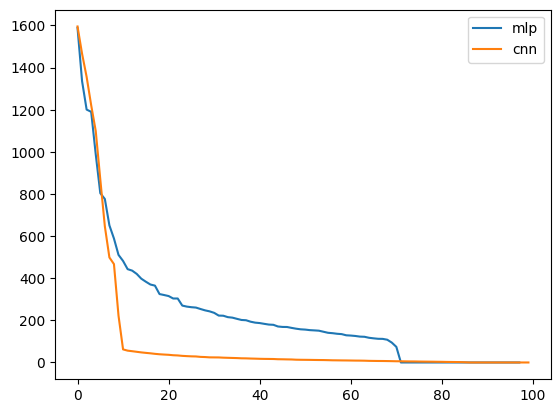

In [ ]:
for model_type, (Z, U, S, Vh) in zip(models, Zs):
    plt.plot(S, label=model_type)
plt.legend()

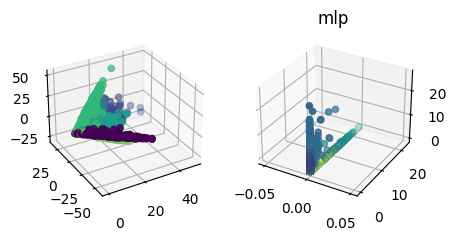

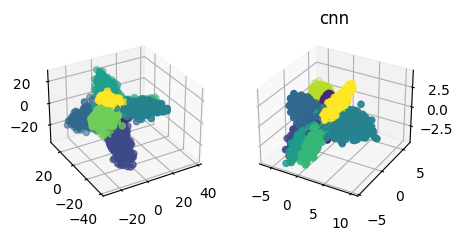

In [ ]:
n=5000
for model_type, (Z, U, S, Vh) in zip(models, Zs):
# plt.scatter3d(*(U*S)[:n,:2].T, c=y_train[:n])
    # fig, ((ax1, ax2)) = plt.subplots(2, 1)
    # print(model_type)
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(211, projection='3d', title=model_type)
    # ax.title(model_type)
    ax.scatter(*(Z)[:n,:3].T, c=y_test[:n])
    ax = fig.add_subplot(221, projection='3d')
    ax.scatter(*(U*S)[:n,:3].T, c=y_test[:n])
    ax.view_init(elev=30, azim=-120)

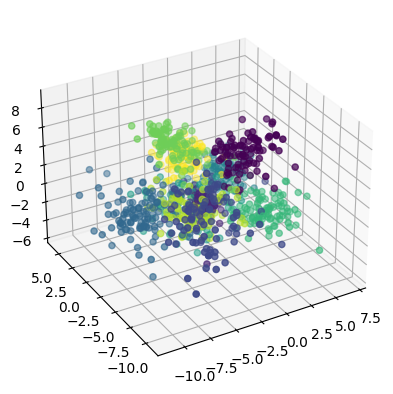

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*(U2*S2)[:n,:3].T, c=y_test[:n])
ax.view_init(elev=30, azim=-120)

In [ ]:
# import plotly.express as px
# fig = px.scatter_3d(*(U2*S2)[:n,:3].T, color=y_test[:n])
# fig.show()

## Prediction

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred = net.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.9631428571428572

An accuracy of about 96% for a network with only one hidden layer is not too bad.

Let's take a look at some predictions that went wrong:

In [ ]:
error_mask = y_pred != y_test

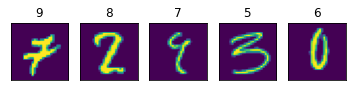

In [ ]:
plot_example(X_test[error_mask], y_pred[error_mask])

# Convolutional Network
PyTorch expects a 4 dimensional tensor as input for its 2D convolution layer. The dimensions represent:
* Batch size
* Number of channel
* Height
* Width

As initial batch size the number of examples needs to be provided. MNIST data has only one channel. As stated above, each MNIST vector represents a 28x28 pixel image. Hence, the resulting shape for PyTorch tensor needs to be (x, 1, 28, 28).

((52500, 1, 28, 28), (52500,))

In [ ]:
cnn.fit(XCnn_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.2683       0.9737        0.0860  2.1423
      2        0.0601       0.9815        0.0607  1.6533
      3        0.0404       0.9837        0.0537  1.6546
      4        0.0294       0.9854        0.0525  1.6434
      5        0.0234       0.9873        0.0475  1.6352
      6        0.0166       0.9849        0.0577  1.6832
      7        0.0153       0.9844        0.0629  1.7376
      8        0.0134       0.9861        0.0547  2.0124
      9        0.0130       0.9868        0.0540  1.6749
     10        0.0127       0.9870        0.0498  1.6912
     11        0.0102       0.9882        0.0501  1.6456
     12        0.0067       0.9883        0.0670  1.6568
     13        0.0077       0.9876        0.0569  1.6514
     14        0.0070       0.9871        0.0567  1.7590
     15        0.0083       0.9902        0.0457  2.0364
     16        0.0081       0.9

In [ ]:
model_c = cnn.module_
# W2, b2 = model_c.W()

Z_test_c = model_c.rep(torch.tensor(XCnn_test).to(device)).to('cpu').detach().numpy()
print(Z_test_c.shape)
U_c, S_c, Vh_c = np.linalg.svd(Z_test_c, full_matrices=False)


(17500, 100)


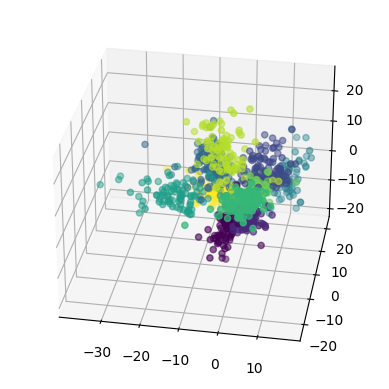

In [ ]:
n=1000
# plt.scatter3d(*(U*S)[:n,:2].T, c=y_train[:n])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*(U_c*S_c)[:n,:3].T, c=y_test[:n])
ax.view_init(elev=30, azim=-80)

In [ ]:
y_pred_cnn = cnn.predict(XCnn_test)

In [ ]:
accuracy_score(y_test, y_pred_cnn)

0.9866857142857143

An accuracy of >98% should suffice for this example!

Let's see how we fare on the examples that went wrong before:

In [ ]:
accuracy_score(y_test[error_mask], y_pred_cnn[error_mask])

0.7705426356589147

Over 70% of the previously misclassified images are now correctly identified.

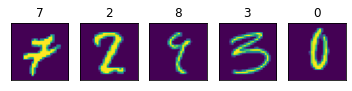

In [ ]:
plot_example(X_test[error_mask], y_pred_cnn[error_mask])